## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

In [80]:
# !pip install http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl 
# !pip install torchvision
# !pip install --upgrade tensorflow-gpu
# !pip install unidecode inflect librosa tensorboardX

#### Import libraries and setup matplotlib

In [81]:
import matplotlib
import matplotlib.pylab as plt
import IPython.display as ipd
import numpy as np
import torch

from data_utils import TextMelLoader
from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from synthesis import synthesis_griffin_lim
%matplotlib inline

In [82]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [83]:
hparams = create_hparams("distributed_run=False,mask_padding=False")
hparams.filter_length = 1024
hparams.hop_length = 256
hparams.win_length = 1024

INFO:tensorflow:Parsing command line hparams: distributed_run=False,mask_padding=False


#### Load model from checkpoint

In [84]:
checkpoint_path = "/home/qianhuang/tacotron2/outdir_avocado_small/checkpoint_26500"
# checkpoint_path = "/home/qianhuang/tacotron2/outdir_lr1e-4/checkpoint_30000"
model = load_model(hparams)
try:
    model = model.module
except:
    pass
model.load_state_dict({k.replace('module.',''):v for k,v in torch.load(checkpoint_path)['state_dict'].items()})
# model.cpu()
print("evaluating...")
_ = model.eval()
print("done")

/home/qianhuang/tacotron2/layers.py:35: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))
/home/qianhuang/tacotron2/layers.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  gain=torch.nn.init.calculate_gain(w_init_gain))


evaluating...
done


#### Prepare text input

In [85]:
text = "niu2 niu2 ge1,"
sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
#print(sequence)
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### label mel

In [86]:
hparams = create_hparams('sampling_rate=44100')
trainset = TextMelLoader(hparams.training_files, hparams)
label_mel = trainset.get_mel('/datasets/AVOCADO/raw_small_data/20180805_data/大富翁的烦心事/clips/1 牛牛哥，.wav')
label_mel_tensor = torch.tensor(label_mel).unsqueeze(0)
hparams = create_hparams('sampling_rate=16000')
trainset = TextMelLoader(hparams.training_files, hparams)
label_mel_2 = trainset.get_mel('/datasets/AVOCADO/small_data/guoguo/wavs/avocado-guoguo-0.wav')
label_mel_2tensor = torch.tensor(label_mel_2).unsqueeze(0)

INFO:tensorflow:Parsing command line hparams: sampling_rate=44100
INFO:tensorflow:Parsing command line hparams: sampling_rate=16000


#### Decode text input and plot results

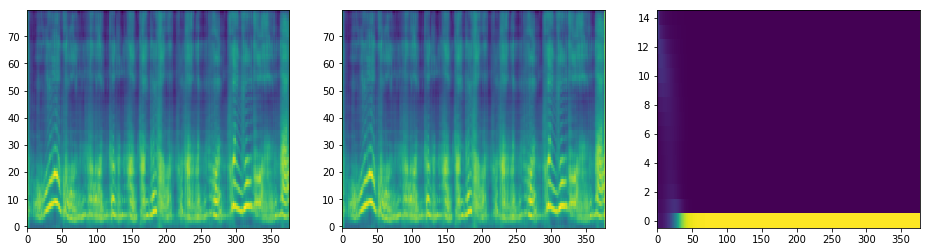

In [87]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))

#### Load TacotronSTFT and convert mel-spectrogram to spectrogram

In [88]:
taco_stft = TacotronSTFT(
    hparams.filter_length, hparams.hop_length, hparams.win_length, 
    sampling_rate=hparams.sampling_rate)
mel_decompress = taco_stft.spectral_de_normalize(mel_outputs_postnet)
mel_decompress = mel_decompress.transpose(1, 2).data.cpu()
spec_from_mel_scaling = 1000
spec_from_mel = torch.mm(mel_decompress[0], taco_stft.mel_basis)
spec_from_mel = spec_from_mel.transpose(0, 1).unsqueeze(0)
spec_from_mel = spec_from_mel * spec_from_mel_scaling

#### Synthesize audio from spectrogram using the Griffin-Lim algorithm

In [89]:
waveform = griffin_lim(torch.autograd.Variable(spec_from_mel[:, :, :-1]), 
                       taco_stft.stft_fn, 60)

In [90]:
#synthesis_griffin_lim(label_mel_tensor,hparams)

In [91]:
ipd.Audio(waveform[0].data.cpu().numpy(), rate=hparams.sampling_rate) 

#### transform tacotron mel to wavenet mel

In [21]:
import librosa.core.time_frequency as t

def _normalize(S):
    return np.clip((S + 100) / 100, 0, 1)


def _denormalize(S):
    return (np.clip(S, 0, 1) * 100) - 100

def _amp_to_db(x):
    min_level = np.exp(-100 / 20 * np.log(10))
    return 20 * np.log10(np.maximum(min_level, x))


In [22]:
mel_np = mel_outputs_postnet.data.cpu().numpy()[0].T

axis = np.linspace(t.hz_to_mel(125), t.hz_to_mel(7600),80)
trimed = np.zeros(mel_np.shape)
for i in range(mel_np.shape[0]):
    for j in range(mel_np.shape[1]):
        trimed[i][j] = mel_np[i][(int)(axis[j]*80/t.hz_to_mel(11025))]
    

In [23]:
wavenet_mel = _normalize(_amp_to_db(np.exp(trimed) ) - 20) 

In [24]:
# np.save('/home/qianhuang/30000iter_droppedlr_ex.npy',mel_np)
# np.save('/home/qianhuang/30000iter_droppedlr_ex.npy',wavenet_mel)
# np.save('/home/qianhuang/24500iter_ex.npy',mel_np)
np.save('/home/qianhuang/24500iter_ex.npy',wavenet_mel)

